# Caso Práctico 1: Predicción de Precios con Redes Neuronales

## Descarga del Conjunto de Datos desde Kaggle

In [44]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Alumno_AI\.cache\kagglehub\datasets\yasserh\housing-prices-dataset\versions\1


### Carga del Conjunto de Datos en un DataFrame

In [46]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
tweets_file = 'C:/Users/Alumno_AI/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1/Housing.csv'
df = pd.read_csv(tweets_file)
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


## Exploración de Datos

In [48]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install --upgrade --no-cache-dir numpy==2.1

Note: you may need to restart the kernel to use updated packages.


In [50]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd

print("Valores únicos después de limpieza:", df["furnishingstatus"].unique())

Valores únicos después de limpieza: ['furnished' 'semi-furnished' 'unfurnished']


In [52]:
yes_no_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in yes_no_cols:
    if col in df.columns:
        print(f"Valores únicos en '{col}':", df[col].unique())


Valores únicos en 'mainroad': ['yes' 'no']
Valores únicos en 'guestroom': ['no' 'yes']
Valores únicos en 'basement': ['no' 'yes']
Valores únicos en 'hotwaterheating': ['no' 'yes']
Valores únicos en 'airconditioning': ['yes' 'no']
Valores únicos en 'prefarea': ['yes' 'no']


### Esto es para deshabilitar un warning

In [53]:
pd.set_option('future.no_silent_downcasting', True)

In [54]:
# Cuenta el número de filas (registros) en el DataFrame
num_filas = len(df)
print(f"El número de registros en el DataFrame es: {num_filas}")

El número de registros en el DataFrame es: 545


## Preprocesamiento y Aumento de Datos con K-Means

En esta celda, se realizan varias etapas clave en la preparación y aumento de datos para mejorar la diversidad y cantidad de muestras en el conjunto de datos:

### 1. **Carga y Preprocesamiento de Datos**
   - Se cargan los datos originales y se aplican transformaciones para garantizar su correcto formato:
     - Se convierten las columnas binarias (`yes/no`) en valores numéricos (`0/1`).
     - Se aplican **variables dummy** (One-Hot Encoding) a la columna `furnishingstatus`.
     - Se eliminan valores `NaN` para evitar problemas en los cálculos posteriores.

### 2. **Definición de Características y Variable Objetivo**
   - `X`: Contiene todas las características relevantes excepto el precio.
   - `y`: Contiene la variable objetivo (`price`).

### 3. **Aumento de Datos mediante Interpolación en Clústeres**
   - Se aplica **K-Means Clustering** para agrupar los datos en `n_clusters=5` categorías similares.
   - Dentro de cada clúster:
     - Se eligen pares de muestras aleatoriamente.
     - Se realiza interpolación lineal entre estas muestras para generar nuevos puntos de datos.
     - Se agrega un pequeño ruido gaussiano para simular variaciones naturales.

### 4. **Postprocesamiento y Guardado**
   - Se aseguran valores binarios coherentes en las columnas categóricas (`yes/no`).
   - Se combinan los datos originales con los sintéticos.
   - Se guardan los nuevos conjuntos de datos (`x_combined.csv` y `y_combined.csv`) para su posterior análisis y modelado.

Este procedimiento ayuda a **mitigar el problema de datos insuficientes** y **mejorar la capacidad del modelo** para generalizar mejor sobre el conjunto de datos.


In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Cargar datos originales
df = pd.read_csv(tweets_file)

# Definir columnas binarias para conversión posterior
yes_no_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Función de preprocesamiento de datos antes de la generación de datos sintéticos
def preprocess(X):
    if not isinstance(X, pd.DataFrame):
        raise ValueError("Los datos deben ser un DataFrame.")

    # Convertir columnas yes/no a valores 0 y 1
    for col in yes_no_cols:
        if col in X.columns:
            X[col] = X[col].astype(str).str.strip().str.lower().replace({'yes': 1, 'no': 0})
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

    # Convertir 'furnishingstatus' en variables dummy (One-Hot Encoding) y eliminar la columna original
    if 'furnishingstatus' in X.columns:
        X = pd.get_dummies(X, columns=['furnishingstatus'], dtype=int)

    # Asegurar que no haya NaN en las columnas generadas
    for col in ['furnishingstatus_furnished', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']:
        if col in X.columns:
            X[col] = X[col].fillna(0)

    X.fillna(0, inplace=True)  # Llenar cualquier otro NaN con 0
    return X

# Aplicar preprocesamiento antes de definir X e y
df = preprocess(df)

# Definir X (características) y y (variable objetivo)
X = df.drop(columns=['price'])
y = df['price']

# Función para aumentar datos mediante interpolación dentro de clústeres
def augment_data(X, y, num_samples, n_clusters=5):
    np.random.seed(42)

    # Preprocesar los datos antes de la generación de datos
    X = preprocess(X)

    # Convertir todas las columnas en numéricas
    X = X.apply(pd.to_numeric, errors='coerce')

    # Agrupar datos en clústeres similares
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    X['cluster'] = kmeans.labels_

    X_aug, y_aug = [], []
    
    for cluster in range(n_clusters):
        cluster_data = X[X['cluster'] == cluster].drop(columns=['cluster'])
        cluster_target = y[X.index.isin(cluster_data.index)]

        idx1 = np.random.randint(0, len(cluster_data), num_samples // n_clusters)
        idx2 = np.random.randint(0, len(cluster_data), num_samples // n_clusters)

        alpha = np.random.uniform(0, 1, len(idx1)).reshape(-1, 1)

        # Interpolación dentro del clúster
        X1, X2 = cluster_data.iloc[idx1].values, cluster_data.iloc[idx2].values
        y1, y2 = cluster_target.iloc[idx1].values, cluster_target.iloc[idx2].values

        X_cluster_aug = alpha * X1 + (1 - alpha) * X2
        y_cluster_aug = alpha.flatten() * y1 + (1 - alpha.flatten()) * y2

        # Añadir ruido proporcional a la escala de las características
        noise_X = np.random.normal(0, 0.01 * cluster_data.std(axis=0), X_cluster_aug.shape)
        noise_y = np.random.normal(0, 0.01 * cluster_target.std(), y_cluster_aug.shape)

        X_cluster_aug += noise_X
        y_cluster_aug += noise_y

        X_aug.append(X_cluster_aug)
        y_aug.append(y_cluster_aug)

    # Concatenar los datos generados
    X_aug = pd.DataFrame(np.vstack(X_aug), columns=X.columns.drop('cluster'))
    y_aug = pd.Series(np.concatenate(y_aug), name=y.name)

    # Asegurar valores binarios coherentes en las columnas yes/no
    for col in yes_no_cols:
        if col in X_aug.columns:
            X_aug[col] = X_aug[col].round().clip(0, 1)  

    return X_aug, y_aug

# Generar datos sintéticos
num_samples = 2000 
X_aug, y_aug = augment_data(X, y, num_samples)

# Aplicar One-Hot Encoding a los datos generados
X_aug = preprocess(X_aug)

# Combinar datos originales y aumentados
X_combined = pd.concat([X, X_aug], axis=0)
y_combined = pd.concat([y, y_aug], axis=0)

# Guardar los datos generados
X_combined.to_csv('x_combined.csv', index=False)
y_combined.to_csv('y_combined.csv', index=False)

print(f"Datos originales: {len(X)} registros")
print(f"Datos aumentados: {len(X_aug)} registros")
print(f"Total de datos: {len(X_combined)} registros")

# Verificar si furnishingstatus sigue existiendo
print(X_combined.head())
print(X_combined.columns)


Datos originales: 545 registros
Datos aumentados: 2000 registros
Total de datos: 2545 registros
     area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  7420.0       4.0        2.0      3.0       1.0        0.0       0.0   
1  8960.0       4.0        4.0      4.0       1.0        0.0       0.0   
2  9960.0       3.0        2.0      2.0       1.0        0.0       1.0   
3  7500.0       4.0        2.0      2.0       1.0        0.0       1.0   
4  7420.0       4.0        1.0      2.0       1.0        1.0       1.0   

   hotwaterheating  airconditioning  parking  prefarea  \
0              0.0              1.0      2.0       1.0   
1              0.0              1.0      3.0       0.0   
2              0.0              0.0      2.0       1.0   
3              0.0              1.0      3.0       1.0   
4              0.0              1.0      2.0       0.0   

   furnishingstatus_furnished  furnishingstatus_semi-furnished  \
0                         1.0               

In [56]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### Visualización de la Distribución de Precios: Datos Originales vs. Aumentados

En esta celda se genera una **gráfica de densidad Kernel (KDE)** para comparar la distribución de los precios originales con los precios generados mediante aumento de datos. 

#### ¿Qué muestra esta gráfica?
- **Línea azul**: Representa la distribución de los precios en el conjunto de datos original.
- **Línea naranja**: Representa la distribución de los precios en los datos sintéticos generados.
- Permite evaluar si los datos aumentados mantienen una distribución similar a los originales, lo cual es clave para evitar sesgos en el modelo.

Este análisis es importante para garantizar que la ampliación de datos no introduce desviaciones significativas en la variable objetivo (`price`).

C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_1696\581867775.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, label="Original", shade=True, color="blue")
C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_1696\581867775.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_aug, label="Aumentado", shade=True, color="orange")


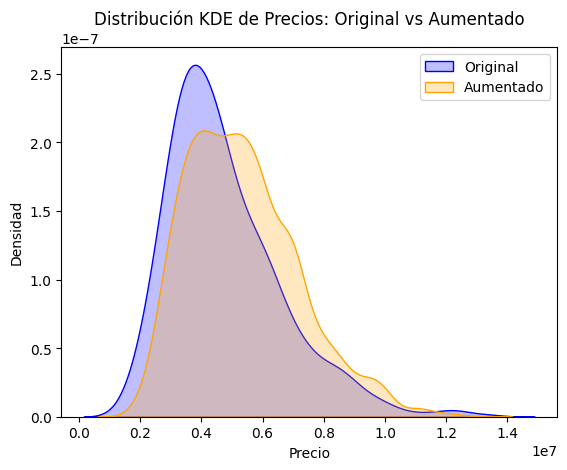

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comparar distribuciones de precios originales vs. aumentados
sns.kdeplot(y, label="Original", shade=True, color="blue")
sns.kdeplot(y_aug, label="Aumentado", shade=True, color="orange")
plt.title("Distribución KDE de Precios: Original vs Aumentado")
plt.xlabel("Precio")
plt.ylabel("Densidad")
plt.legend()
plt.show()

### Comparación de la Distribución de Precios: Original vs. Aumentado  

En esta celda se realiza una **comparación de la distribución de precios** entre los datos originales y los datos sintéticos generados.  

#### ¿Qué muestra esta gráfica?
- Se utiliza un **histograma** para visualizar la frecuencia de los valores de `price`.
- **Barras superpuestas**:  
  - **Datos originales**: Se muestran en un color.  
  - **Datos aumentados**: Se muestran en otro color con transparencia.  
- Permite analizar si la generación de datos sintéticos mantiene una distribución similar a los datos originales.  

Este análisis es clave para verificar la **coherencia estadística** de los datos aumentados y asegurarse de que no se introducen sesgos significativos en la distribución.


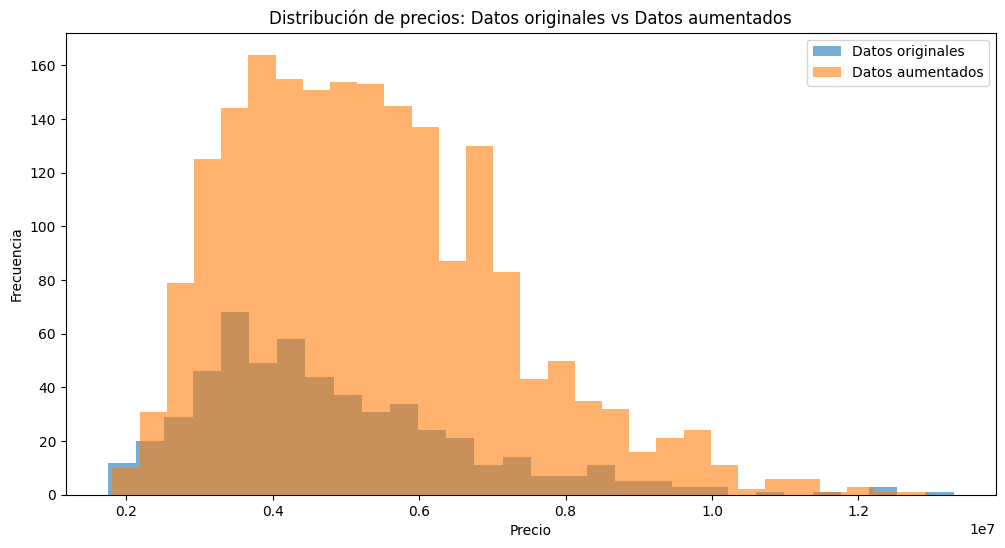

In [58]:
import matplotlib.pyplot as plt

# Comparación de la distribución de una característica (por ejemplo, 'price')
plt.figure(figsize=(12, 6))

plt.hist(y, bins=30, alpha=0.6, label='Datos originales')
plt.hist(y_aug, bins=30, alpha=0.6, label='Datos aumentados')

plt.legend()
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios: Datos originales vs Datos aumentados')
plt.show()

### Comparación de la Distribución de Precios con Boxplot  

En esta celda se visualiza la **distribución de precios** entre los datos originales y los datos aumentados utilizando un **boxplot**.  

#### ¿Qué representa este gráfico?
- **Eje X**: Diferencia entre el conjunto de datos **original** y **aumentado**.
- **Eje Y**: Valores de `price` en cada conjunto.
- **Boxplot (diagrama de caja y bigotes)**:
  - Muestra la **mediana** de los datos.
  - Indica la **dispersión** y presencia de **valores atípicos**.
  - Permite detectar si los datos aumentados tienen una distribución similar a los originales.

Este análisis es útil para verificar que los datos sintéticos **mantienen la estructura estadística** del conjunto original sin generar valores fuera de rango.


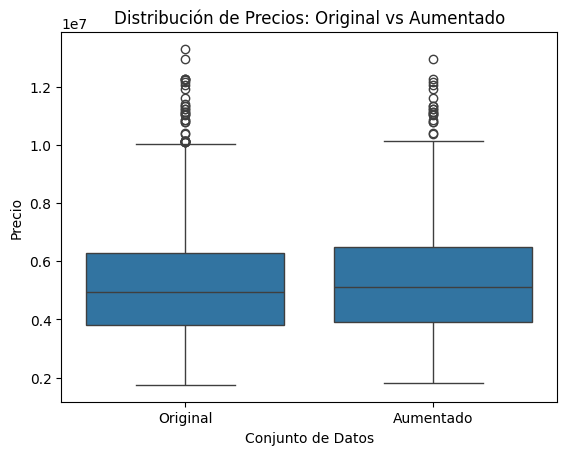

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurar que y y y_aug sean 1D
y = y.squeeze()
y_aug = y_aug.squeeze()

# Crear un DataFrame temporal para visualizar ambos conjuntos de datos
data_visual = pd.DataFrame({
    "Precio": pd.concat([y, y_aug]),
    "Conjunto": ["Original"] * len(y) + ["Aumentado"] * len(y_aug)
})

sns.boxplot(x="Conjunto", y="Precio", data=data_visual)
plt.title("Distribución de Precios: Original vs Aumentado")
plt.xlabel("Conjunto de Datos")
plt.ylabel("Precio")
plt.show()


In [60]:
X_combined.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,7420.0,4.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0
1,8960.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0
2,9960.0,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
3,7500.0,4.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0
4,7420.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0


## Ingeniería de Características en el Conjunto de Datos

En esta celda, hemos aplicado varias técnicas de **ingeniería de características** al conjunto de datos combinado. El objetivo es **mejorar la calidad de los datos** para los modelos de predicción, creando nuevas características basadas en relaciones matemáticas entre las variables originales.

### Nuevas Características Generadas:
- **Relaciones de características**:
  - `bathrooms_per_area`: Número de baños por área.
  - `stories_per_area`: Número de pisos por área.
  - `parking_per_area`: Número de estacionamientos por área.
  - `bathrooms_per_bedroom`: Relación entre baños y dormitorios.
  - `bed_room_per_area`: Número de dormitorios por área.

- **Total de habitaciones y tamaño promedio**:
  - `rooms_total`: Total de habitaciones (dormitorios + baños).
  - `avg_room_size`: Tamaño promedio de cada habitación.
  - `room_density`: Densidad de habitaciones por área.

- **Relaciones adicionales**:
  - `bedrooms_per_bathroom`: Relación de dormitorios por baño.
  - `area_per_story`: Área por piso.
  - `parking_per_bedroom`: Estacionamientos por dormitorio.
  - `parking_area_ratio`: Relación entre estacionamientos y área total.

- **Características de servicios**:
  - Se generan un índice de servicios basado en variables categóricas binarias como `mainroad`, `guestroom`, etc.
  - Se crean nuevas características como `service_index`, `parking_service_ratio`, y `service_area_ratio`.

- **Relación entre características específicas**:
  - `guestroom_basement`: Indica si la casa tiene tanto un cuarto de huéspedes como un sótano (valor binario).

### Propósito de la Ingeniería:
Este proceso busca crear **características adicionales** que podrían ser útiles para el modelo de predicción, basadas en interacciones entre las variables, mejorando la capacidad de los algoritmos para aprender patrones significativos en los datos.

Finalmente, los datos generados con la ingeniería de características se guardan en un nuevo archivo CSV llamado `df_final.csv`.


In [61]:
# Aplicar ingeniería de características a los datos combinados
df = X_combined.copy()
df['price'] = y_combined  # Volver a añadir la variable objetivo

# Crear nuevas características basadas en relaciones matemáticas
df['bathrooms_per_area'] = df['bathrooms'] / df['area']
df['stories_per_area'] = df['stories'] / df['area']
df['parking_per_area'] = df['parking'] / df['area']
df['bathrooms_per_bedroom'] = df['bathrooms'] / df['bedrooms']
df['bed_room_per_area'] = df['bedrooms'] / df['area']

# Total de habitaciones
df['rooms_total'] = df['bedrooms'] + df['bathrooms']

# Tamaño promedio de cada habitación
df['avg_room_size'] = df['area'] / df['rooms_total']
df['room_density'] = df['rooms_total'] / df['area']

# Relación de dormitorios a baños
df['bedrooms_per_bathroom'] = df['bedrooms'] / df['bathrooms']

# Área por piso
df['area_per_story'] = df['area'] / df['stories']

# Estacionamientos por dormitorio
df['parking_per_bedroom'] = df['parking'] / df['bedrooms']
df['parking_area_ratio'] = df['parking'] * df['area']

# Convertir columnas yes/no a valores numéricos (ya lo hicimos en la generación de datos)
for col in yes_no_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower().replace({'yes': 1, 'no': 0})
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Crear un índice de servicios basado en variables categóricas binarias
df['service_index'] = df[yes_no_cols].sum(axis=1)
df['parking_service_ratio'] = df['parking'] / (df['service_index'] + 1)
df['service_area_ratio'] = df['service_index'] / df['area']

# Relación entre la existencia de cuarto de huéspedes y sótano
df['guestroom_basement'] = (df['guestroom'].astype(int) & df['basement'].astype(int))

# Guardar el DataFrame con ingeniería de características
df.to_csv('df_final.csv', index=False)

print(f"Datos finales con ingeniería de características guardados en 'df_final.csv'.")


Datos finales con ingeniería de características guardados en 'df_final.csv'.


### Limpieza de Datos y Manejo de Valores Faltantes

Este dataset está limpio, pero en esta celda, se aplican técnicas para **limpiar los datos** y **manejar los valores faltantes** en el conjunto de datos:

### Pasos Realizados:

1. **Cálculo de la cantidad de registros antes y después de la limpieza**:
   - Se imprime la cantidad de filas del conjunto de datos **original** (`X_combined`) y el número de filas después de eliminar valores faltantes.

2. **Imputación de valores faltantes**:
   - Se imputan los valores faltantes en el conjunto de datos utilizando la **mediana** de cada columna. Esto es especialmente útil para las características numéricas, ya que la mediana es menos sensible a los valores atípicos que la media.

3. **Eliminación de filas con valores faltantes en la columna objetivo**:
   - Se eliminan las filas que tienen un valor **NaN** en la columna de precios (`price`), ya que no podemos realizar una predicción sin este valor.

4. **Identificación y eliminación de columnas vacías**:
   - Se identifican las columnas que están completamente vacías (sin valores) y se eliminan del conjunto de datos, ya que no aportan valor a la predicción.

In [63]:
print(f"Filas originales: {len(X_combined)}")
print(f"Filas después de eliminar NaN: {len(df)}")

df.fillna(df.median(), inplace=True)  # Imputa con la mediana de cada columna

df = df.dropna(subset=['price'])  # Asegúrate de que la columna de precios se llama 'price'

empty_cols = [col for col in df.columns if df[col].isna().all()]
print(f"Columnas completamente vacías: {empty_cols}")

df = df.drop(columns=empty_cols)

Filas originales: 2545
Filas después de eliminar NaN: 2545
Columnas completamente vacías: []


#### Cálculo del precio promedio, simplemente por saber el dato

In [64]:
avg_price = df['price'].mean()
print(f"El precio promedio de las viviendas es: {avg_price:.2f}")

El precio promedio de las viviendas es: 5219671.79


In [65]:
pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Guardar las Columnas Originales del Conjunto de Datos

En esta celda, se guarda la lista de las **columnas originales**, después de hacer featuring engineering, pero antes de usar PolynomialFeaturing. Necesito este .pkl como checkpoint en la api (para hacer más fácil la validación de que antes de hacer poly está todo en orden)

### Pasos Realizados:

1. **Extracción de las columnas iniciales**:
   - Se guarda la lista de las **columnas originales** del conjunto de datos `X` (sin la columna objetivo `price`) en una variable llamada `original_columns`.

2. **Guardado de las columnas originales**:
   - La lista `original_columns` se guarda en un archivo llamado `original_columns.pkl` utilizando la librería `joblib`. Esto permite que las columnas originales se conserven y puedan ser cargadas más tarde si se necesitan para alguna referencia o restauración.

#### Propósito:
Poder usar este archivo en la api para poder recrear todas las columnas pre **PolynomialFeaturing**

In [66]:
import joblib

X = df.drop(columns=['price'])

# Columnas iniciales antes de cualquier transformación
original_columns = list(X.columns)  # Guardar las columnas originales (sin la columna objetivo)
joblib.dump(original_columns, 'original_columns.pkl')  # Guardar las columnas originales en un archivo


['original_columns.pkl']

In [62]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [91]:
pip install optuna-dashboard

   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
   -------------------------------- ------- 6.8/8.4 MB 38.1 MB/s eta 0:00:01
   ---------------------------------------- 8.4/8.4 MB 37.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Optimización de Hiperparámetros con Optuna para Predicción de Precios

Esta celda se enfoca en la optimización de los **hiperparámetros** de un modelo de **red neuronal profunda** para predecir precios de propiedades inmobiliarias, utilizando el **framework Optuna** para realizar la búsqueda de hiperparámetros y mejorar el rendimiento del modelo.

### Pasos Realizados:

1. **Escalado de Datos**:
   - Los datos de entrada (`X`) y la variable objetivo (`y`) se escalan utilizando el `RobustScaler`.

2. **PolynomialFeaturing**:
   - Se genera un conjunto de características polinómicas de grado 2, solo con interacciones, lo que podría ayudar a capturar relaciones no lineales entre las características.

3. **Definición del Modelo**:
   - Un modelo de **red neuronal profunda** (DNN) es creado con múltiples capas ocultas, **Dropout**, y **BatchNormalization** para evitar el sobreajuste y mejorar la generalización.
   - El modelo usa una función de activación **Swish** y una **pérdida de Huber** para hacer el modelo robusto a outliers.

4. **Optuna para Optimización de Hiperparámetros**:
   - La optimización de hiperparámetros se realiza utilizando **Optuna**, una librería para la búsqueda eficiente de hiperparámetros.
   - Los hiperparámetros optimizados incluyen:
     - Tipo de optimizador (`Nadam` o `Adam`)
     - Tasa de **dropout**
     - Tasa de **aprendizaje**
     - Regularización **L2**
     - Unidades en las capas ocultas
     - Tamaño de batch para entrenamiento

5. **Entrenamiento con Validación Cruzada**:
   - Se utiliza **validación cruzada k-fold** (5 pliegues) para evaluar el rendimiento del modelo con diferentes combinaciones de hiperparámetros, asegurando que el modelo generalice bien.

6. **Entrenamiento Final del Modelo**:
   - Una vez encontrados los mejores hiperparámetros, el modelo es entrenado en el conjunto completo de datos con un número mayor de épocas (350) y utilizando **EarlyStopping**, **ReduceLROnPlateau**, y **ModelCheckpoint** como callbacks para evitar sobreajuste y mejorar la convergencia.

7. **Evaluación del Modelo Final**:
   - Finalmente, se evalúa el rendimiento del modelo utilizando varias métricas:
     - **MAE** (Error Absoluto Medio)
     - **MSE** (Error Cuadrático Medio)
     - **RMSE** (Raíz del Error Cuadrático Medio)
     - **R²** (Coeficiente de Determinación)
   - Además, se calcula el **Error porcentual** en el modelo desescalado para obtener una medida comprensible del error en relación con la media de los precios.

### Resultados:
- La salida del modelo incluye las métricas de rendimiento y un **porcentaje de error** que indica qué tan bien el modelo predice en comparación con los valores reales desescalados.


In [92]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import optuna
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

df = pd.read_csv('df_final.csv')  # Cargar el archivo CSV 'df_final.csv' en un DataFrame

# Reconfigurar X y y después de eliminar los NaN
X = df.drop(columns=['price'])
y = df[['price']]

# Escalar los datos
scaler_X = RobustScaler()
scaler_y = RobustScaler()

# Ajustar y transformar los datos de entrada
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)  # Ahora se escala correctamente

# Generar características polinómicas
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

def objective(trial):
    try:
        # Ajustar rangos de hiperparámetros
        optimizer_name = trial.suggest_categorical('optimizer', ['nadam', 'adam'])
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        l2_rate = trial.suggest_float('l2_rate', 1e-7, 1e-3)
        hidden_units_1 = trial.suggest_int('hidden_units_1', 64, 256, step=64)
        hidden_units_2 = trial.suggest_int('hidden_units_2', 32, 128, step=32)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        # Crear modelo ajustado
        model = build_model(optimizer_name, dropout_rate, learning_rate, l2_rate, hidden_units_1, hidden_units_2)

        # Configuración de callbacks
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Aplicar k-fold cross-validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        mse_scores = []

        for train_idx, val_idx in kfold.split(X_poly):
            X_train, X_val = X_poly[train_idx], X_poly[val_idx]
            y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

            # Entrenar modelo en este fold
            model.fit(X_train, y_train, epochs=150, batch_size=batch_size, verbose=0,
                      validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
            y_val_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_val_pred)
            mse_scores.append(mse)

        # Devuelve la métrica promedio de los folds
        return np.mean(mse_scores)
    except Exception as e:
        print(f"Error durante la optimización: {e}")
        return float('inf')



# Crear el modelo con las modificaciones respetando tu lógica original de optimizador
def build_model(optimizer_name, dropout_rate, learning_rate, l2_rate, hidden_units_1, hidden_units_2):
    model = Sequential()

    # Primera capa con BatchNormalization y Swish
    model.add(Dense(hidden_units_1, kernel_initializer=HeNormal(), kernel_regularizer=l1_l2(l2=l2_rate), input_shape=(X_poly.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation('swish'))
    model.add(Dropout(dropout_rate))

    # Capas ocultas con Dropout dinámico
    for layer_index in range(3):  # Tres capas ocultas dinámicas
        units = hidden_units_2 // (2 ** layer_index)  # Reducir unidades exponencialmente
        model.add(Dense(units, kernel_initializer=HeNormal(), kernel_regularizer=l1_l2(l2=l2_rate)))
        model.add(BatchNormalization())
        model.add(Activation('swish'))
        model.add(Dropout(dropout_rate * (layer_index + 1) * 0.8))

    # Capa de salida
    model.add(Dense(1))

    optimizer = Nadam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))  # Cambié a Huber Loss

    return model

# Función para realizar los estudios con Optuna
def run_optimizer_trials():
    study = optuna.create_study(study_name='trials_pisos', storage='sqlite:///optuna_study.db', load_if_exists=True, direction='minimize')
    study.optimize(objective, n_trials=50)  # Mantengo las 50 pruebas originales

    print(f"\nMejores hiperparámetros:")
    print(study.best_params)
    return study.best_params

# Ejecutar los estudios
best_params = run_optimizer_trials()

# Crear modelo final con los mejores hiperparámetros
final_model = build_model(best_params['optimizer'], best_params['dropout_rate'], best_params['learning_rate'], best_params['l2_rate'], best_params['hidden_units_1'], best_params['hidden_units_2'])

# Configurar callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

X_train, X_val, y_train, y_val = train_test_split(X_poly, y_scaled, test_size=0.2, random_state=42)

history = final_model.fit(X_train, y_train, epochs=350, batch_size=best_params['batch_size'], verbose=1,
                          validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluación final del modelo
y_val_pred = final_model.predict(X_val)

y_val_descaled = scaler_y.inverse_transform(y_val)
y_val_pred_descaled = scaler_y.inverse_transform(y_val_pred)

mae = mean_absolute_error(y_val_descaled, y_val_pred_descaled)
mse = mean_squared_error(y_val_descaled, y_val_pred_descaled)
rmse = np.sqrt(mean_squared_error(y_val_descaled, y_val_pred_descaled))
r2 = r2_score(y_val_descaled, y_val_pred_descaled)

print(f"\nResultados finales del modelo:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

rmse_percentage_descaled = (rmse / np.mean(y_val_descaled)) * 100
print(f"Error porcentual (desescalado): {rmse_percentage_descaled:.2f}%")

[I 2025-03-27 13:02:54,442] A new study created in RDB with name: trials_pisos
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:04:27,789] Trial 0 finished with value: 0.05010781117330926 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.285634621743122, 'learning_rate': 0.001953393174658017, 'l2_rate': 0.0004362551513912484, 'hidden_units_1': 256, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 0 with value: 0.05010781117330926.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:05:17,016] Trial 1 finished with value: 0.044725772140875274 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.16301753819274312, 'learning_rate': 0.002381433499709224, 'l2_rate': 0.0006602925136382796, 'hidden_units_1': 256, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 1 with value: 0.044725772140875274.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:06:20,059] Trial 2 finished with value: 0.09740674942225411 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.1997115702522383, 'learning_rate': 0.00010233634417233941, 'l2_rate': 8.134243602295832e-06, 'hidden_units_1': 64, 'hidden_units_2': 64, 'batch_size': 32}. Best is trial 1 with value: 0.044725772140875274.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:07:08,209] Trial 3 finished with value: 0.05303370714504431 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.21502694870787883, 'learning_rate': 0.0006621403032214001, 'l2_rate': 0.00026623145453648497, 'hidden_units_1': 64, 'hidden_units_2': 64, 'batch_size': 64}. Best is trial 1 with value: 0.044725772140875274.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:08:05,301] Trial 4 finished with value: 0.07767022362224525 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.258374263400814, 'learning_rate': 0.00047232549488225155, 'l2_rate': 0.00027362930673742046, 'hidden_units_1': 256, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 1 with value: 0.044725772140875274.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:10:39,734] Trial 5 finished with value: 0.03828285467474843 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.03874786189852656, 'learning_rate': 0.00013608106458764743, 'l2_rate': 0.000990594058675957, 'hidden_units_1': 256, 'hidden_units_2': 64, 'batch_size': 16}. Best is trial 5 with value: 0.03828285467474843.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:11:19,243] Trial 6 finished with value: 0.030316515589314457 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.0715775456938421, 'learning_rate': 0.0012230625923793676, 'l2_rate': 0.0006339188696434288, 'hidden_units_1': 64, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 6 with value: 0.030316515589314457.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:13:02,877] Trial 7 finished with value: 0.0464215713601615 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.21158766495054962, 'learning_rate': 0.0030503126752218575, 'l2_rate': 0.00021702716573079235, 'hidden_units_1': 128, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 6 with value: 0.030316515589314457.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:15:04,209] Trial 8 finished with value: 0.036242730737688744 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.06770929681855423, 'learning_rate': 0.0007772070329779191, 'l2_rate': 0.0008423189802836834, 'hidden_units_1': 256, 'hidden_units_2': 64, 'batch_size': 16}. Best is trial 6 with value: 0.030316515589314457.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:16:53,573] Trial 9 finished with value: 0.060552010089689634 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.2556945186374385, 'learning_rate': 0.0001588978941469317, 'l2_rate': 0.0008246341096151768, 'hidden_units_1': 192, 'hidden_units_2': 64, 'batch_size': 32}. Best is trial 6 with value: 0.030316515589314457.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:17:40,463] Trial 10 finished with value: 0.04139390942247485 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.10678700839875485, 'learning_rate': 0.008954068002126994, 'l2_rate': 0.0005566760828021664, 'hidden_units_1': 128, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 6 with value: 0.030316515589314457.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:19:24,146] Trial 11 finished with value: 0.033515575231145976 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.049672720926951935, 'learning_rate': 0.00038703814216871943, 'l2_rate': 0.0007889268343002111, 'hidden_units_1': 192, 'hidden_units_2': 96, 'batch_size': 16}. Best is trial 6 with value: 0.030316515589314457.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:21:33,264] Trial 12 finished with value: 0.024653490855724516 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.014031262100057229, 'learning_rate': 0.00030238712819541445, 'l2_rate': 0.0007300809311936891, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 12 with value: 0.024653490855724516.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:23:44,456] Trial 13 finished with value: 0.025487098467414586 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.004331523242400423, 'learning_rate': 0.0002569941469970254, 'l2_rate': 0.0006292147919505154, 'hidden_units_1': 128, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 12 with value: 0.024653490855724516.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:25:41,568] Trial 14 finished with value: 0.02634005573920527 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.01629788326701434, 'learning_rate': 0.00026350936803719907, 'l2_rate': 0.000459824031242541, 'hidden_units_1': 128, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 12 with value: 0.024653490855724516.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:27:47,823] Trial 15 finished with value: 0.022882581322126404 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.0073076570535060255, 'learning_rate': 0.0002407782333046029, 'l2_rate': 0.0007030114776227856, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:30:03,883] Trial 16 finished with value: 0.03477093255841897 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.11674390177205549, 'learning_rate': 0.00023352973682319006, 'l2_rate': 0.0009444662684017289, 'hidden_units_1': 192, 'hidden_units_2': 96, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:32:19,149] Trial 17 finished with value: 0.03379765214042827 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.10076685935949502, 'learning_rate': 0.00041088729808015146, 'l2_rate': 0.0007357852453630104, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:34:09,023] Trial 18 finished with value: 0.039337759430968185 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.14439380476755537, 'learning_rate': 0.0011826236252183355, 'l2_rate': 0.0003858316199799242, 'hidden_units_1': 192, 'hidden_units_2': 96, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:37:03,176] Trial 19 finished with value: 0.029821499918404094 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.02864613293033136, 'learning_rate': 0.00016052588637799508, 'l2_rate': 0.0007157384314321452, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:38:00,667] Trial 20 finished with value: 0.03908501528650273 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.0027838990777744156, 'learning_rate': 0.004843642816603899, 'l2_rate': 0.0008719088496836927, 'hidden_units_1': 128, 'hidden_units_2': 128, 'batch_size': 32}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:40:07,213] Trial 21 finished with value: 0.026593791397644007 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.0003637700677322584, 'learning_rate': 0.00026845161561848106, 'l2_rate': 0.0006060288090121399, 'hidden_units_1': 128, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:42:23,964] Trial 22 finished with value: 0.03196622346059349 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.059911658233937064, 'learning_rate': 0.0002275184858147935, 'l2_rate': 0.0005541267114873066, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:44:38,950] Trial 23 finished with value: 0.03393451512038096 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.07997233754569025, 'learning_rate': 0.000527923576902257, 'l2_rate': 0.0007096251916909538, 'hidden_units_1': 128, 'hidden_units_2': 96, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:47:03,094] Trial 24 finished with value: 0.02595792737945435 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.03101562415986493, 'learning_rate': 0.00029093219402872656, 'l2_rate': 0.0005340487587368826, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:50:02,790] Trial 25 finished with value: 0.036198585354745905 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.0008773890903226705, 'learning_rate': 0.00010407017108846135, 'l2_rate': 0.0009031026219638011, 'hidden_units_1': 128, 'hidden_units_2': 96, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:52:10,268] Trial 26 finished with value: 0.028216548980934064 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.027771177126764225, 'learning_rate': 0.00018943572009456607, 'l2_rate': 0.0007708147943737493, 'hidden_units_1': 192, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:54:04,644] Trial 27 finished with value: 0.031225918731796316 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.08513405569974583, 'learning_rate': 0.00036039031507941805, 'l2_rate': 0.0006636724021389399, 'hidden_units_1': 128, 'hidden_units_2': 128, 'batch_size': 16}. Best is trial 15 with value: 0.022882581322126404.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:55:07,628] Trial 28 finished with value: 0.021939183473614267 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.0483626348436208, 'learning_rate': 0.000816493314642902, 'l2_rate': 0.0003862856717141926, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 28 with value: 0.021939183473614267.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:55:53,745] Trial 29 finished with value: 0.027534047064523635 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.04720191292137517, 'learning_rate': 0.0017828080442105706, 'l2_rate': 0.0003776372209133442, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 28 with value: 0.021939183473614267.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:56:53,734] Trial 30 finished with value: 0.03485027637697301 and parameters: {'optimizer': 'adam', 'dropout_rate': 0.1320684429332073, 'learning_rate': 0.0008432338804639035, 'l2_rate': 0.00013150951802723317, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 28 with value: 0.021939183473614267.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:57:51,235] Trial 31 finished with value: 0.018884219724163633 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.01822383028482529, 'learning_rate': 0.0006021944547685338, 'l2_rate': 0.0004595692941164605, 'hidden_units_1': 64, 'hidden_units_2': 128, 'batch_size': 32}. Best is trial 31 with value: 0.018884219724163633.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 13:58:52,693] Trial 32 finished with value: 0.018180513334921426 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.02018255174133714, 'learning_rate': 0.0006031642795685922, 'l2_rate': 0.00045293476724625313, 'hidden_units_1': 64, 'hidden_units_2': 128, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 13:59:56,553] Trial 33 finished with value: 0.0227861558147018 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.049809874890973514, 'learning_rate': 0.0005869309460592374, 'l2_rate': 0.00040690539163605453, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:01:01,664] Trial 34 finished with value: 0.035329011168158765 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.16955208802269292, 'learning_rate': 0.0005632750837431121, 'l2_rate': 0.0003820392126666554, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:01:55,017] Trial 35 finished with value: 0.027367663271539742 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.05221048145106357, 'learning_rate': 0.0015932950843352846, 'l2_rate': 0.0004333700789295676, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:02:46,689] Trial 36 finished with value: 0.03198391591521258 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.09072254739895884, 'learning_rate': 0.0010407362053856896, 'l2_rate': 0.0003293776494702433, 'hidden_units_1': 64, 'hidden_units_2': 64, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 14:03:48,763] Trial 37 finished with value: 0.03705642963337248 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.17246465068038377, 'learning_rate': 0.0006947758780391941, 'l2_rate': 0.0004839942553144972, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:04:26,582] Trial 38 finished with value: 0.03180767166703948 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.036709892027943995, 'learning_rate': 0.0025637193371223577, 'l2_rate': 0.000187027858949171, 'hidden_units_1': 64, 'hidden_units_2': 64, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:05:26,707] Trial 39 finished with value: 0.023543349375890477 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.06588036609916559, 'learning_rate': 0.000570712698905585, 'l2_rate': 0.00031541569124513957, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:06:16,553] Trial 40 finished with value: 0.022576771604680457 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.022727593314292215, 'learning_rate': 0.0014179795089250575, 'l2_rate': 7.566235425698334e-05, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:06:58,004] Trial 41 finished with value: 0.027562944473214716 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.02076575514039325, 'learning_rate': 0.0014947913945151329, 'l2_rate': 3.690073251087316e-05, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 14:07:53,677] Trial 42 finished with value: 0.027165586019379084 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.0423814857522343, 'learning_rate': 0.000948094006772496, 'l2_rate': 8.641164272640717e-05, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:08:57,294] Trial 43 finished with value: 0.024709867538437395 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.0583275185212038, 'learning_rate': 0.000733499186932809, 'l2_rate': 0.0002379028455276677, 'hidden_units_1': 64, 'hidden_units_2': 64, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:09:57,954] Trial 44 finished with value: 0.026241215487146967 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.07596173013720432, 'learning_rate': 0.0013269421220498407, 'l2_rate': 0.00041452049986144134, 'hidden_units_1': 64, 'hidden_units_2': 96, 'batch_size': 32}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:10:33,270] Trial 45 finished with value: 0.019252399980699716 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.02085577699539612, 'learning_rate': 0.0021112367968353658, 'l2_rate': 0.0003347037291624056, 'hidden_units_1': 64, 'hidden_units_2': 64, 'batch_size': 64}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:11:06,255] Trial 46 finished with value: 0.02076177707084776 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.02154913040980035, 'learning_rate': 0.003386315119517725, 'l2_rate': 0.00031302326620832746, 'hidden_units_1': 64, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 14:11:39,984] Trial 47 finished with value: 0.02437072356212999 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.03601611230427028, 'learning_rate': 0.0046451190439807735, 'l2_rate': 0.00031280208142054396, 'hidden_units_1': 64, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 32 with value: 0.018180513334921426.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2025-03-27 14:12:16,431] Trial 48 finished with value: 0.018144287641880148 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.015122674459569508, 'learning_rate': 0.0036986786183616006, 'l2_rate': 0.0005028431655482757, 'hidden_units_1': 64, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 48 with value: 0.018144287641880148.
c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2025-03-27 14:12:53,908] Trial 49 finished with value: 0.018889155623962074 and parameters: {'optimizer': 'nadam', 'dropout_rate': 0.015695541769861508, 'learning_rate': 0.004562674563294728, 'l2_rate': 0.0005104129952271973, 'hidden_units_1': 64, 'hidden_units_2': 32, 'batch_size': 64}. Best is trial 48 with value: 0.018144287641880148.



Mejores hiperparámetros:
{'optimizer': 'nadam', 'dropout_rate': 0.015122674459569508, 'learning_rate': 0.0036986786183616006, 'l2_rate': 0.0005028431655482757, 'hidden_units_1': 64, 'hidden_units_2': 32, 'batch_size': 64}


c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4935

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.4901 - val_loss: 0.2606 - learning_rate: 0.0037
Epoch 2/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2188

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2183 - val_loss: 0.2302 - learning_rate: 0.0037
Epoch 3/350
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1677

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1675 - val_loss: 0.1664 - learning_rate: 0.0037
Epoch 4/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1558

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1550 - val_loss: 0.1436 - learning_rate: 0.0037
Epoch 5/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1454

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1449 - val_loss: 0.1380 - learning_rate: 0.0037
Epoch 6/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1344

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1343 - val_loss: 0.1272 - learning_rate: 0.0037
Epoch 7/350
16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1232 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1218 - val_loss: 0.1226 - learning_rate: 0.0037
Epoch 8/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1128

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1130 - val_loss: 0.1128 - learning_rate: 0.0037
Epoch 9/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1033 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1037 - val_loss: 0.1080 - learning_rate: 0.0037
Epoch 10/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0999

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0998 - val_loss: 0.0995 - learning_rate: 0.0037
Epoch 11/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0970 - val_loss: 0.1028 - learning_rate: 0.0037
Epoch 12/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0858

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0859 - val_loss: 0.0871 - learning_rate: 0.0037
Epoch 13/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0802 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0828 - val_loss: 0.0827 - learning_rate: 0.0037
Epoch 14/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0846 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832 - val_loss: 0.0784 - learning_rate: 0.0037
Epoch 15/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0788 - val_loss: 0.0800 - learning_rate: 0.0037
Epoch 16/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0739

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0737 - val_loss: 0.0778 - learning_rate: 0.0037
Epoch 17/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0736

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0735 - val_loss: 0.0711 - learning_rate: 0.0037
Epoch 18/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0718 - val_loss: 0.0728 - learning_rate: 0.0037
Epoch 19/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0699

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0700 - val_loss: 0.0642 - learning_rate: 0.0037
Epoch 20/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0709 - val_loss: 0.0652 - learning_rate: 0.0037
Epoch 21/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0637 - val_loss: 0.0657 - learning_rate: 0.0037
Epoch 22/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0633 - val_loss: 0.0610 - learning_rate: 0.0037
Epoch 23/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0588 - val_loss: 0.0673 - learning_rate: 0.0037
Epoch 24/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0630 - val_loss: 0.0563 - learning_rate: 0.0037
Epoch 25/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0596 - val_loss: 0.0654 - learning_rate: 0.0037
Epoch 26/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0617 - val_loss: 0.0588 - learning_rate: 0.0037
Epoch 27/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0540 - val_loss: 0.0674 - learning_rate: 0.0037
Epoch 28/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0581 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0596 - val_loss: 0.0553 - learning_rate: 0.0037
Epoch 29/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0577 - val_loss: 0.0571 - learning_rate: 0.0037
Epoch 30/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0573 - val_loss: 0.0554 - learning_rate: 0.0037
Epoch 31/350
18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0584 - val_loss: 0.0543 - learning_rate: 0.0037
Epoch 32/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0532 - val_loss: 0.0548 - learning_rate: 0.0037
Epoch 33/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0550 - val_loss: 0.0559 - learning_rate: 0.0037
Epoch 34/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0599 - val_loss: 0.0558 - learning_rate: 0.0037
Epoch 35/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0590 - val_loss: 0.0528 - learning_rate: 0.0037
Epoch 36/350
16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0539 - val_loss: 0.0518 - learning_rate: 0.0037
Epoch 37/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0494 - val_loss: 0.0590 - learning_rate: 0.0037
Epoch 38/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0493 - val_loss: 0.0530 - learning_rate: 0.0037
Epoch 39/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0502 - val_loss: 0.0572 - learning_rate: 0.0037
Epoch 40/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0495 - val_loss: 0.0544 - learning_rate: 0.0037
Epoch 41/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0530 - val_loss: 0.0552 - learning_rate: 0.0037
Epoch 42/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0500 - val_loss: 0.0510 - learning_rate: 0.0018
Epoch 43/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0466 - val_loss: 0.0494 - learning_rate: 0.0018
Epoch 44/350
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0413 - val_loss: 0.0487 - learning_rate: 0.0018
Epoch 45/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0414 - val_loss: 0.0463 - learning_rate: 0.0018
Epoch 46/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0378 - val_loss: 0.0443 - learning_rate: 0.0018
Epoch 47/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0438 - val_loss: 0.0578 - learning_rate: 0.0018
Epoch 48/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403 - val_loss: 0.0459 - learning_rate: 0.0018
Epoch 49/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0445 - val_loss: 0.0466 - learning_rate: 0.0018
Epoch 50/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0427 - val_loss: 0.0445 - learning_rate: 0.0018
Epoch 51/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0432 - val_loss: 0.0432 - learning_rate: 0.0018
Epoch 52/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0424 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427 - val_loss: 0.0411 - learning_rate: 0.0018
Epoch 53/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0446 - val_loss: 0.0436 - learning_rate: 0.0018
Epoch 54/350
18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0420 - val_loss: 0.0400 - learning_rate: 0.0018
Epoch 55/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0459 - val_loss: 0.0409 - learning_rate: 0.0018
Epoch 56/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0376 - val_loss: 0.0459 - learning_rate: 0.0018
Epoch 57/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0398 - val_loss: 0.0402 - learning_rate: 0.0018
Epoch 58/350
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0432 - val_loss: 0.0400 - learning_rate: 0.0018
Epoch 59/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0415 - val_loss: 0.0415 - learning_rate: 0.0018
Epoch 60/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0417 - val_loss: 0.0426 - learning_rate: 9.2467e-04
Epoch 61/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0389 - val_loss: 0.0390 - learning_rate: 9.2467e-04
Epoch 62/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0347 - val_loss: 0.0390 - learning_rate: 9.2467e-04
Epoch 63/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0341 - val_loss: 0.0381 - learning_rate: 9.2467e-04
Epoch 64/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384 - val_loss: 0.0378 - learning_rate: 9.2467e-04
Epoch 65/350
20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0324 - val_loss: 0.0371 - learning_rate: 9.2467e-04
Epoch 66/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0348 - val_loss: 0.0376 - learning_rate: 9.2467e-04
Epoch 67/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364 - val_loss: 0.0378 - learning_rate: 9.2467e-04
Epoch 68/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0345 - val_loss: 0.0360 - learning_rate: 9.2467e-04
Epoch 69/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0343 - val_loss: 0.0361 - learning_rate: 9.2467e-04
Epoch 70/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0335

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0335 - val_loss: 0.0346 - learning_rate: 9.2467e-04
Epoch 71/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0347 - val_loss: 0.0355 - learning_rate: 9.2467e-04
Epoch 72/350
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0334

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0336 - val_loss: 0.0318 - learning_rate: 9.2467e-04
Epoch 73/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - val_loss: 0.0357 - learning_rate: 9.2467e-04
Epoch 74/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - val_loss: 0.0331 - learning_rate: 9.2467e-04
Epoch 75/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - val_loss: 0.0362 - learning_rate: 9.2467e-04
Epoch 76/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - val_loss: 0.0328 - learning_rate: 9.2467e-04
Epoch 77/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - val_loss: 0.0356 - learning_rate: 9.2467e-04
Epoch 78/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0337 - val_loss: 0.0339 - learning_rate: 4.6233e-04
Epoch 79/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 - val_loss: 0.0329 - learning_rate: 4.6233e-04
Epoch 80/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - val_loss: 0.0339 - learning_rate

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0271 - val_loss: 0.0308 - learning_rate: 4.6233e-04
Epoch 83/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0325 - val_loss: 0.0326 - learning_rate: 4.6233e-04
Epoch 84/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0306 - val_loss: 0.0297 - learning_rate: 4.6233e-04
Epoch 85/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - val_loss: 0.0318 - learning_rate: 4.6233e-04
Epoch 86/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - val_loss: 0.0313 - learning_rate: 4.6233e-04
Epoch 87/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - val_loss: 0.0325 - learning_rate: 4.6233e-04
Epoch 88/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - val_loss: 0.0314 - learning_rate: 4.6233e-04
Epoch 89/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280 - val_loss: 0.0294 - learning_rate: 4.6233e-04
Epoch 90/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0294 - val_loss: 0.0322 - learning_rate: 4.6233e-04
Epoch 91/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - val_loss: 0.0310 - learning_rate: 4.6233e-04
Epoch 92/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - val_loss: 0.0308 - learning_rate: 4.6233e-04
Epoch 93/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - val_loss: 0.0309 - learning_rate: 4.6233e-04
Epoch 94/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0317 - val_loss: 0.0327 - learning_rate: 4.6233e-04
Epoch 95/350
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - val_loss: 0.0287 - learning_rate: 2.3117e-04
Epoch 96/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287 - val_loss: 0.0300 - learning_rate: 2.3117e-04
Epoch 97/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270 - val_loss: 0.0281 - learning_rate: 2.3117e-04
Epoch 98/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0260 - val_loss: 0.0304 - learning_rate: 2.3117e-04
Epoch 99/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0260 - val_loss: 0.0296 - learning_rate: 2.3117e-04
Epoch 100/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - val_loss: 0.0284 - learning_rate: 2.3117e-04
Epoch 101/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - val_loss: 0.0285 - learning_rate: 2.3117e-04
Epoch 102/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0296 - val_loss: 0.0281 - learning_rate: 2.3117e-04
Epoch 103/350
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 - val_loss: 0.0277 - learning_rate: 1.1558e-04
Epoch 104/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0276 - val_loss: 0.0285 - learning_rate: 1.1558e-04
Epoch 105/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258 - val_loss: 0.0278 - learning_rate: 1.1558e-04
Epoch 106/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.0279 - learning_rate: 1.1558e-04
Epoch 107/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - val_loss: 0.0286 - learning_rate: 1.1558e-04
Epoch 108/350
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - val_loss: 0.0272 - learning_rate: 1.1558e-04
Epoch 109/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0222 - val_loss: 0.0269 - learning_rate: 1.1558e-04
Epoch 110/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0240 - val_loss: 0.0281 - learning_rate: 1.1558e-04
Epoch 111/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - val_loss: 0.0270 - learning_rate: 1.1558e-04
Epoch 112/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0197 - val_loss: 0.0272 - learning_rate: 1.1558e-04
Epoch 113/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - val_loss: 0.0273 - learning_rate: 1.1558e-04
Epoch 114/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0255 - val_loss: 0.0275 - learning_rate: 1.1558e-04
Epoch 115/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - val_loss: 0.0275 - learning_rate: 5.7792e-05
Epoch 116/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0232 - val_loss: 0.0271 - learning_rate: 5.7792e-05
Epoch 117/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.0272 - learn

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0288 - val_loss: 0.0267 - learning_rate: 5.7792e-05
Epoch 119/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 - val_loss: 0.0269 - learning_rate: 5.7792e-05
Epoch 120/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0211 - val_loss: 0.0273 - learning_rate: 5.7792e-05
Epoch 121/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0223 - val_loss: 0.0271 - learning_rate: 5.7792e-05
Epoch 122/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - val_loss: 0.0270 - learning_rate: 5.7792e-05
Epoch 123/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - val_loss: 0.0266 - learning_rate: 5.7792e-05
Epoch 124/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211 - val_loss: 0.0268 - learning_rate: 5.7792e-05
Epoch 125/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0240 - val_loss: 0.0270 - learning_rate: 5.7792e-05
Epoch 126/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0269 - learning_rate: 5.7792e-05
Epoch 127/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - val_loss: 0.0271 - learning_rate: 5.7792e-05
Epoch 128/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - val_loss: 0.0277 - learning_rate: 5.7792e-05
Epoch 129/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0274 - learning_rate: 2.8896e-05
Epoch 130/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - val_loss: 0.0272 - learning_rate: 2.8896e-05
Epoch 131/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - val_loss: 0.0269 - learn

### Para ver info del estudio de Optuna (ejecutar en terminal)

In [ ]:
#!optuna-dashboard sqlite:///optuna_study.db --host localhost --port 8081

Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Scripts\optuna-dashboard.exe\__main__.py", line 7, in <module>
  File "c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\optuna_dashboard\_cli.py", line 140, in main
    run_wsgiref(app, args.host, args.port, args.quiet)
  File "c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\optuna_dashboard\_cli.py", line 43, in run_wsgiref
    httpd = make_server(host, port, app, server_class=ThreadedWSGIServer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Alumno_AI\AppData\Local\Programs\Python\Python311\Lib\wsgiref\simple_server.py", line 154, in make_server
    server = server_class((host, port), handler_class)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

## Entrenamiento del modelo sin tener que usar el optimizador de parámetros
Esta celda solo la ejecuto cuando quiero probar cambiando yo algo de los parámetros sin tener que estar ejecutando los 50 trials

### Definir los parámetros (si los queremos cambiar)

In [ ]:
# df = pd.read_csv('df_final.csv')  # Cargar el archivo CSV 'df_final.csv' en un DataFrame

# # Reconfigurar X y y después de eliminar los NaN
# X = df.drop(columns=['price'])
# y = df[['price']]

# # Escalar los datos
# scaler_X = RobustScaler()
# scaler_y = RobustScaler()

# # Ajustar y transformar los datos de entrada
# X_scaled = scaler_X.fit_transform(X)
# y_scaled = scaler_y.fit_transform(y)  # Ahora se escala correctamente

# # Generar características polinómicas
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X_poly = poly.fit_transform(X_scaled)

# model = Sequential()

#     # Primera capa con BatchNormalization y Swish
# model.add(Dense(192, kernel_initializer=HeNormal(), kernel_regularizer=l1_l2(l2=0.0003639032564986888), input_shape=(X_poly.shape[1],)))
# model.add(BatchNormalization())
# model.add(Activation('swish'))
# model.add(Dropout(0.002574930645769016))

#     # Capas ocultas con Dropout dinámico
# for layer_index in range(3):  # Tres capas ocultas dinámicas
#     units = 64 // (2 ** layer_index)  # Reducir unidades exponencialmente
#     model.add(Dense(units, kernel_initializer=HeNormal(), kernel_regularizer=l1_l2(l2=0.0003639032564986888)))
#     model.add(BatchNormalization())
#     model.add(Activation('swish'))
#     model.add(Dropout(0.002574930645769016 * (layer_index + 1) * 0.8))

#     # Capa de salida
# model.add(Dense(1))

# optimizer = Nadam(learning_rate=0.0004449958154327974)

# model.compile(optimizer=optimizer, loss=Huber(delta=1.0))  # Cambié a Huber Loss

c:\Users\Alumno_AI\Desktop\Generativa\Sam\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Entrenar el modelo

In [83]:
# Configurar callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

X_train, X_val, y_train, y_val = train_test_split(X_poly, y_scaled, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=350, batch_size=64, verbose=1,
                          validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluación final del modelo
y_val_pred = model.predict(X_val)

Epoch 1/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5153

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5104 - val_loss: 0.3402 - learning_rate: 4.4500e-04
Epoch 2/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3327

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3293 - val_loss: 0.3119 - learning_rate: 4.4500e-04
Epoch 3/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2987

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2979 - val_loss: 0.2898 - learning_rate: 4.4500e-04
Epoch 4/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2803

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2796 - val_loss: 0.2751 - learning_rate: 4.4500e-04
Epoch 5/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2655

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2653 - val_loss: 0.2646 - learning_rate: 4.4500e-04
Epoch 6/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2616

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2617 - val_loss: 0.2547 - learning_rate: 4.4500e-04
Epoch 7/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2546

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2544 - val_loss: 0.2523 - learning_rate: 4.4500e-04
Epoch 8/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2515

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2503 - val_loss: 0.2447 - learning_rate: 4.4500e-04
Epoch 9/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2416

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2422 - val_loss: 0.2417 - learning_rate: 4.4500e-04
Epoch 10/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2439

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2429 - val_loss: 0.2346 - learning_rate: 4.4500e-04
Epoch 11/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2375

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2374 - val_loss: 0.2295 - learning_rate: 4.4500e-04
Epoch 12/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2343

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2327 - val_loss: 0.2225 - learning_rate: 4.4500e-04
Epoch 13/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2264

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2263 - val_loss: 0.2202 - learning_rate: 4.4500e-04
Epoch 14/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2267

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2255 - val_loss: 0.2188 - learning_rate: 4.4500e-04
Epoch 15/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2169

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2165 - val_loss: 0.2137 - learning_rate: 4.4500e-04
Epoch 16/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2141

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2139 - val_loss: 0.2113 - learning_rate: 4.4500e-04
Epoch 17/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2113

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2112 - val_loss: 0.2107 - learning_rate: 4.4500e-04
Epoch 18/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2091

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2084 - val_loss: 0.2029 - learning_rate: 4.4500e-04
Epoch 19/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2065

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2063 - val_loss: 0.2010 - learning_rate: 4.4500e-04
Epoch 20/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2027

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2014 - val_loss: 0.1986 - learning_rate: 4.4500e-04
Epoch 21/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1958

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1957 - val_loss: 0.1946 - learning_rate: 4.4500e-04
Epoch 22/350
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1922

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1922 - val_loss: 0.1925 - learning_rate: 4.4500e-04
Epoch 23/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1875

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1879 - val_loss: 0.1913 - learning_rate: 4.4500e-04
Epoch 24/350
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1845

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1845 - val_loss: 0.1867 - learning_rate: 4.4500e-04
Epoch 25/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1856

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1842 - val_loss: 0.1811 - learning_rate: 4.4500e-04
Epoch 26/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1784 - val_loss: 0.1814 - learning_rate: 4.4500e-04
Epoch 27/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1749

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1759 - val_loss: 0.1764 - learning_rate: 4.4500e-04
Epoch 28/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1771

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1764 - val_loss: 0.1723 - learning_rate: 4.4500e-04
Epoch 29/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1687

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1690 - val_loss: 0.1703 - learning_rate: 4.4500e-04
Epoch 30/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1666

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1662 - val_loss: 0.1691 - learning_rate: 4.4500e-04
Epoch 31/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1659

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1665 - val_loss: 0.1671 - learning_rate: 4.4500e-04
Epoch 32/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1603

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1603 - val_loss: 0.1635 - learning_rate: 4.4500e-04
Epoch 33/350
20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1593

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1596 - val_loss: 0.1600 - learning_rate: 4.4500e-04
Epoch 34/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1567

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1567 - val_loss: 0.1599 - learning_rate: 4.4500e-04
Epoch 35/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1547

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1547 - val_loss: 0.1579 - learning_rate: 4.4500e-04
Epoch 36/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1524

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1525 - val_loss: 0.1567 - learning_rate: 4.4500e-04
Epoch 37/350
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1455

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1456 - val_loss: 0.1517 - learning_rate: 4.4500e-04
Epoch 38/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1469

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1469 - val_loss: 0.1499 - learning_rate: 4.4500e-04
Epoch 39/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1428

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1428 - val_loss: 0.1453 - learning_rate: 4.4500e-04
Epoch 40/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1399

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1406 - val_loss: 0.1447 - learning_rate: 4.4500e-04
Epoch 41/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1404

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1397 - val_loss: 0.1420 - learning_rate: 4.4500e-04
Epoch 42/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1346

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1347 - val_loss: 0.1399 - learning_rate: 4.4500e-04
Epoch 43/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1348 - val_loss: 0.1405 - learning_rate: 4.4500e-04
Epoch 44/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1329

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1325 - val_loss: 0.1373 - learning_rate: 4.4500e-04
Epoch 45/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1333

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1324 - val_loss: 0.1359 - learning_rate: 4.4500e-04
Epoch 46/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1255

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1260 - val_loss: 0.1323 - learning_rate: 4.4500e-04
Epoch 47/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1270

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1265 - val_loss: 0.1307 - learning_rate: 4.4500e-04
Epoch 48/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1223

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1229 - val_loss: 0.1295 - learning_rate: 4.4500e-04
Epoch 49/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1188

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1191 - val_loss: 0.1256 - learning_rate: 4.4500e-04
Epoch 50/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1205

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1203 - val_loss: 0.1228 - learning_rate: 4.4500e-04
Epoch 51/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1159 - val_loss: 0.1228 - learning_rate: 4.4500e-04
Epoch 52/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1199

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1198 - val_loss: 0.1228 - learning_rate: 4.4500e-04
Epoch 53/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1168

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1165 - val_loss: 0.1196 - learning_rate: 4.4500e-04
Epoch 54/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1141

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1141 - val_loss: 0.1171 - learning_rate: 4.4500e-04
Epoch 55/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1103

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1103 - val_loss: 0.1155 - learning_rate: 4.4500e-04
Epoch 56/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1097

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1097 - val_loss: 0.1131 - learning_rate: 4.4500e-04
Epoch 57/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1066

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1067 - val_loss: 0.1119 - learning_rate: 4.4500e-04
Epoch 58/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1036

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1038 - val_loss: 0.1095 - learning_rate: 4.4500e-04
Epoch 59/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1031 - val_loss: 0.1096 - learning_rate: 4.4500e-04
Epoch 60/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1011

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1012 - val_loss: 0.1068 - learning_rate: 4.4500e-04
Epoch 61/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1028

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1027 - val_loss: 0.1053 - learning_rate: 4.4500e-04
Epoch 62/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0982 - val_loss: 0.1060 - learning_rate: 4.4500e-04
Epoch 63/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0979 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0985 - val_loss: 0.1023 - learning_rate: 4.4500e-04
Epoch 64/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0988

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0983 - val_loss: 0.1014 - learning_rate: 4.4500e-04
Epoch 65/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0959 - val_loss: 0.1016 - learning_rate: 4.4500e-04
Epoch 66/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0928

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0929 - val_loss: 0.1001 - learning_rate: 4.4500e-04
Epoch 67/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0921

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0929 - val_loss: 0.0993 - learning_rate: 4.4500e-04
Epoch 68/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0893

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0894 - val_loss: 0.0967 - learning_rate: 4.4500e-04
Epoch 69/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0863

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0868 - val_loss: 0.0930 - learning_rate: 4.4500e-04
Epoch 70/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0891 - val_loss: 0.0935 - learning_rate: 4.4500e-04
Epoch 71/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0842

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0844 - val_loss: 0.0918 - learning_rate: 4.4500e-04
Epoch 72/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0874

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0871 - val_loss: 0.0911 - learning_rate: 4.4500e-04
Epoch 73/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0824

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0832 - val_loss: 0.0899 - learning_rate: 4.4500e-04
Epoch 74/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0820 - val_loss: 0.0907 - learning_rate: 4.4500e-04
Epoch 75/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0816

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0823 - val_loss: 0.0897 - learning_rate: 4.4500e-04
Epoch 76/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0860

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0852 - val_loss: 0.0889 - learning_rate: 4.4500e-04
Epoch 77/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0809

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0808 - val_loss: 0.0873 - learning_rate: 4.4500e-04
Epoch 78/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0778

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0779 - val_loss: 0.0866 - learning_rate: 4.4500e-04
Epoch 79/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0771

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0773 - val_loss: 0.0860 - learning_rate: 4.4500e-04
Epoch 80/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0769

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0769 - val_loss: 0.0831 - learning_rate: 4.4500e-04
Epoch 81/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0766 - val_loss: 0.0828 - learning_rate: 4.4500e-04
Epoch 82/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0767

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0764 - val_loss: 0.0807 - learning_rate: 4.4500e-04
Epoch 83/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0777

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0765 - val_loss: 0.0791 - learning_rate: 4.4500e-04
Epoch 84/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0741 - val_loss: 0.0792 - learning_rate: 4.4500e-04
Epoch 85/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0716

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0716 - val_loss: 0.0777 - learning_rate: 4.4500e-04
Epoch 86/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0694

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0696 - val_loss: 0.0774 - learning_rate: 4.4500e-04
Epoch 87/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0710

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0708 - val_loss: 0.0767 - learning_rate: 4.4500e-04
Epoch 88/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0707

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0701 - val_loss: 0.0765 - learning_rate: 4.4500e-04
Epoch 89/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0669

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0671 - val_loss: 0.0757 - learning_rate: 4.4500e-04
Epoch 90/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0696 - val_loss: 0.0759 - learning_rate: 4.4500e-04
Epoch 91/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0678

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0683 - val_loss: 0.0736 - learning_rate: 4.4500e-04
Epoch 92/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0646

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0647 - val_loss: 0.0717 - learning_rate: 4.4500e-04
Epoch 93/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0666 - val_loss: 0.0718 - learning_rate: 4.4500e-04
Epoch 94/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0628

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0629 - val_loss: 0.0713 - learning_rate: 4.4500e-04
Epoch 95/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0655

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0658 - val_loss: 0.0693 - learning_rate: 4.4500e-04
Epoch 96/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0629 - val_loss: 0.0717 - learning_rate: 4.4500e-04
Epoch 97/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0626

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0625 - val_loss: 0.0691 - learning_rate: 4.4500e-04
Epoch 98/350
20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0614

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0615 - val_loss: 0.0680 - learning_rate: 4.4500e-04
Epoch 99/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0626

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0626 - val_loss: 0.0675 - learning_rate: 4.4500e-04
Epoch 100/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0648 - val_loss: 0.0695 - learning_rate: 4.4500e-04
Epoch 101/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0561

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0566 - val_loss: 0.0648 - learning_rate: 4.4500e-04
Epoch 102/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0567

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0569 - val_loss: 0.0638 - learning_rate: 4.4500e-04
Epoch 103/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0570 - val_loss: 0.0653 - learning_rate: 4.4500e-04
Epoch 104/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0590 - val_loss: 0.0639 - learning_rate: 4.4500e-04
Epoch 105/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0560 - val_loss: 0.0628 - learning_rate: 4.4500e-04
Epoch 106/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0567

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0570 - val_loss: 0.0613 - learning_rate: 4.4500e-04
Epoch 107/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0540

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0542 - val_loss: 0.0603 - learning_rate: 4.4500e-04
Epoch 108/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0544

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0545 - val_loss: 0.0602 - learning_rate: 4.4500e-04
Epoch 109/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0515

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0521 - val_loss: 0.0597 - learning_rate: 4.4500e-04
Epoch 110/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0518 - val_loss: 0.0603 - learning_rate: 4.4500e-04
Epoch 111/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0516

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0517 - val_loss: 0.0586 - learning_rate: 4.4500e-04
Epoch 112/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0520 - val_loss: 0.0601 - learning_rate: 4.4500e-04
Epoch 113/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0546

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0543 - val_loss: 0.0583 - learning_rate: 4.4500e-04
Epoch 114/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0502

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0506 - val_loss: 0.0576 - learning_rate: 4.4500e-04
Epoch 115/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0494

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0499 - val_loss: 0.0546 - learning_rate: 4.4500e-04
Epoch 116/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485 - val_loss: 0.0581 - learning_rate: 4.4500e-04
Epoch 117/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0487 - val_loss: 0.0563 - learning_rate: 4.4500e-04
Epoch 118/350
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0500

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0498 - val_loss: 0.0541 - learning_rate: 4.4500e-04
Epoch 119/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0486 - val_loss: 0.0561 - learning_rate: 4.4500e-04
Epoch 120/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0465

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0465 - val_loss: 0.0539 - learning_rate: 4.4500e-04
Epoch 121/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0495 - val_loss: 0.0549 - learning_rate: 4.4500e-04
Epoch 122/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0482 - val_loss: 0.0549 - learning_rate: 4.4500e-04
Epoch 123/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0447 - val_loss: 0.0624 - learning_rate: 4.4500e-04
Epoch 124/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0442

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0449 - val_loss: 0.0530 - learning_rate: 4.4500e-04
Epoch 125/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0482 - val_loss: 0.0533 - learning_rate: 4.4500e-04
Epoch 126/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0451 - val_loss: 0.0547 - learning_rate: 4.4500e-04
Epoch 127/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0445

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0445 - val_loss: 0.0529 - learning_rate: 4.4500e-04
Epoch 128/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0433 - val_loss: 0.0534 - learning_rate: 4.4500e-04
Epoch 129/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427 - val_loss: 0.0539 - learning_rate: 4.4500e-04
Epoch 130/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0465

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0465 - val_loss: 0.0501 - learning_rate: 2.2250e-04
Epoch 131/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0447

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0439 - val_loss: 0.0490 - learning_rate: 2.2250e-04
Epoch 132/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0405 - val_loss: 0.0495 - learning_rate: 2.2250e-04
Epoch 133/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0386

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0387 - val_loss: 0.0487 - learning_rate: 2.2250e-04
Epoch 134/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0398 - val_loss: 0.0488 - learning_rate: 2.2250e-04
Epoch 135/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0399 - val_loss: 0.0502 - learning_rate: 2.2250e-04
Epoch 136/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0390

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0391 - val_loss: 0.0480 - learning_rate: 2.2250e-04
Epoch 137/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371 - val_loss: 0.0482 - learning_rate: 2.2250e-04
Epoch 138/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0383 - val_loss: 0.0494 - learning_rate: 2.2250e-04
Epoch 139/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0401 - val_loss: 0.0484 - learning_rate: 2.2250e-04
Epoch 140/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0386 - val_loss: 0.0497 - learning_rate: 2.2250e-04
Epoch 141/350
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0389

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0389 - val_loss: 0.0479 - learning_rate: 2.2250e-04
Epoch 142/350
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0374

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0374 - val_loss: 0.0472 - learning_rate: 2.2250e-04
Epoch 143/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0359 - val_loss: 0.0469 - learning_rate: 2.2250e-04
Epoch 144/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0378 - val_loss: 0.0474 - learning_rate: 2.2250e-04
Epoch 145/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 - val_loss: 0.0470 - learning_rate: 2.2250e-04
Epoch 146/350
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0375

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0376 - val_loss: 0.0469 - learning_rate: 2.2250e-04
Epoch 147/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0350 - val_loss: 0.0461 - learning_rate: 2.2250e-04
Epoch 148/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0391 - val_loss: 0.0467 - learning_rate: 2.2250e-04
Epoch 149/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381 - val_loss: 0.0470 - learning_rate: 2.2250e-04
Epoch 150/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0342 - val_loss: 0.0464 - learning_rate: 2.2250e-04
Epoch 151/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0360 - val_loss: 0.0474 - learning_rate: 2.2250e-04
Epoch 152/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0387 - val_loss: 0.0465 - learning_rate: 2.2250e-04
Epoch 153/350
20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0335 - val_loss: 0.0448 - learning_rate: 1.1125e-04
Epoch 154/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0347 - val_loss: 0.0447 - learning_rate: 1.1125e-04
Epoch 155/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0343 - val_loss: 0.0445 - learning_rate: 1.1125e-04
Epoch 156/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346 - val_loss: 0.0447 - learning_rate: 1.1125e-04
Epoch 157/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0334 - val_loss: 0.0447 - learning_rate: 1.1125e-04
Epoch 158/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0326 - val_loss: 0.0446 - learning_rate: 1.1125e-04
Epoch 159/350
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0323

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0324 - val_loss: 0.0442 - learning_rate: 1.1125e-04
Epoch 160/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0347 - val_loss: 0.0447 - learning_rate: 1.1125e-04
Epoch 161/350
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0326 - val_loss: 0.0441 - learning_rate: 1.1125e-04
Epoch 162/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0375

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0374 - val_loss: 0.0439 - learning_rate: 1.1125e-04
Epoch 163/350
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0331 - val_loss: 0.0431 - learning_rate: 1.1125e-04
Epoch 164/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 - val_loss: 0.0435 - learning_rate: 1.1125e-04
Epoch 165/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0341 - val_loss: 0.0437 - learning_rate: 1.1125e-04
Epoch 166/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307 - val_loss: 0.0438 - learning_rate: 1.1125e-04
Epoch 167/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0347 - val_loss: 0.0439 - learning_rate: 1.1125e-04
Epoch 168/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0360 - val_loss: 0.0441 - learning_rate: 1.1125e-04
Epoch 169/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0325 - val_loss: 0.0436 - learning_rate: 5.5624e-05
Epoch 170/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 - val_loss: 0.0433 - learning_rate: 5.5624e-05
Epoch 171/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0316 - val_loss: 0.0429 - learning_rate: 5.5624e-05
Epoch 172/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0322 - val_loss: 0.0427 - learning_rate: 5.5624e-05
Epoch 173/350
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0311 - val_loss: 0.0426 - learning_rate: 5.5624e-05
Epoch 174/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0303 - val_loss: 0.0430 - learning_rate: 5.5624e-05
Epoch 175/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0306 - val_loss: 0.0433 - learning_rate: 5.5624e-05
Epoch 176/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0302 - val_loss: 0.0428 - learning_rate: 5.5624e-05
Epoch 177/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0305 - val_loss: 0.0433 - learning_rate: 5.5624e-05
Epoch 178/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - val_loss: 0.0428 - learning_rate: 5.5624e-05
Epoch 179/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 - val_loss: 0.0426 - learning_rate: 2.7812e-05
Epoch 180/350
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0312 - val_loss: 0.0425 - learning_rate: 2.7812e-05
Epoch 181/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0303 - val_loss: 0.0424 - learning_rate: 2.7812e-05
Epoch 182/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0306 - val_loss: 0.0424 - learning_rate: 2.7812e-05
Epoch 183/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0306 - val_loss: 0.0425 - learning_rate: 2.7812e-05
Epoch 184/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0336 - val_loss: 0.0425 - learning_rate: 2.7812e-05
Epoch 185/350
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0329 - val_loss: 0.0423 - learning_rate: 2.7812e-05
Epoch 186/350
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0325 - val_loss: 0.0421 - learning_rate: 2.7812e-05
Epoch 187/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 - val_loss: 0.0426 - learning_rate: 2.7812e-05
Epoch 188/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0303 - val_loss: 0.0424 - learning_rate: 2.7812e-05
Epoch 189/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314 - val_loss: 0.0424 - learning_rate: 2.7812e-05
Epoch 190/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0300 - val_loss: 0.0426 - learning_rate: 2.7812e-05
Epoch 191/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0297 - val_loss: 0.0426 - learning_rate: 2.7812e-05
Epoch 192/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309 - val_loss: 0.0425 - learning_rate: 1.3906e-05
Epoch 193/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299 - val_loss: 0.0424 - learning_rate: 1.3906e-05
Epoch 194/350
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0306 - val_loss: 0.0424 - learn

## Resultados del Modelo

Las siguientes métricas son utilizadas para evaluar el rendimiento del modelo de regresión. Se presentan tanto en términos absolutos como en términos porcentuales, para dar una mejor comprensión sobre la magnitud del error en relación con la variable objetivo.

In [ ]:
mae = mean_absolute_error(y_val_descaled, y_val_pred_descaled)
mse = mean_squared_error(y_val_descaled, y_val_pred_descaled)
rmse = np.sqrt(mean_squared_error(y_val_descaled, y_val_pred_descaled))
r2 = r2_score(y_val_descaled, y_val_pred_descaled)

print(f"\nResultados finales del modelo:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

### Resultados del Modelo en Porcentaje

In [ ]:
print(f"\nResultados finales del modelo en porcentaje:")
mae_percentage_descaled = (mae / np.mean(y_val_descaled)) * 100
mape = np.mean(np.abs((y_val_descaled - y_val_pred_descaled) / y_val_descaled)) * 100
rmse_percentage_descaled = (rmse / np.mean(y_val_descaled)) * 100


print(f"MAE (porcentaje): {mae_percentage_descaled:.2f}%")
print(f"MSE (porcentaje) / MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RMSE (porcentaje): {rmse_percentage_descaled:.2f}%")


Resultados finales del modelo en porcentaje:
MAE (porcentaje): 6.98%
MSE (porcentaje) / MAPE: 7.90%
RMSE (porcentaje): 9.82%
R²: 0.9233


### Visualizacion de la función de pérdida

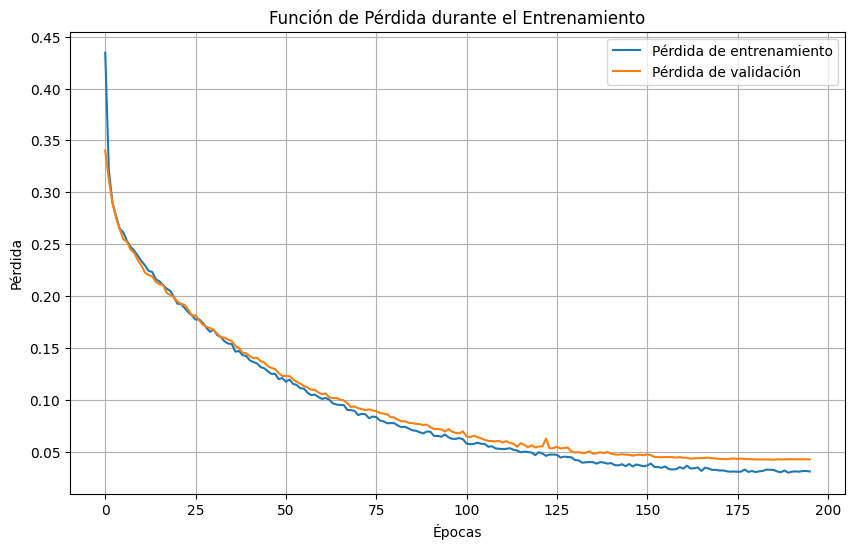

In [89]:
import matplotlib.pyplot as plt

# Graficar la función de pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Función de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

## Resultados de Predicciones

In [ ]:
# Hacer las predicciones sobre los datos
y_test_pred = final_model.predict(X_val)  # Predicciones para los datos de prueba

# Desescalar los valores reales y predichos
y_test_descaled = scaler_y.inverse_transform(y_val)  # Desescalar valores reales
y_test_pred_descaled = scaler_y.inverse_transform(y_test_pred)  # Desescalar predicciones

# Calcular la variación porcentual entre el precio real y el precio predicho
variaciones_porcentuales = np.abs((y_test_pred_descaled - y_test_descaled) / y_test_descaled) * 100

# Mostrar los resultados
print("\nResultados de predicciones:")
for i in range(len(y_test_descaled)):
    print(f"Precio Real: {y_test_descaled[i][0]:.2f}, Precio Predicho: {y_test_pred_descaled[i][0]:.2f}, Variación: {variaciones_porcentuales[i][0]:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Resultados de predicciones:
Precio Real: 7343000.00, Precio Predicho: 7142915.50, Variación: 2.72%
Precio Real: 3828989.37, Precio Predicho: 3482354.25, Variación: 9.05%
Precio Real: 5837181.21, Precio Predicho: 5066929.50, Variación: 13.20%
Precio Real: 3775162.10, Precio Predicho: 3225864.50, Variación: 14.55%
Precio Real: 3139737.64, Precio Predicho: 3010870.75, Variación: 4.10%
Precio Real: 5038613.59, Precio Predicho: 4552065.00, Variación: 9.66%
Precio Real: 3175113.02, Precio Predicho: 3226397.25, Variación: 1.62%
Precio Real: 7207738.59, Precio Predicho: 7034464.50, Variación: 2.40%
Precio Real: 5005000.00, Precio Predicho: 5177585.50, Variación: 3.45%
Precio Real: 3500000.00, Precio Predicho: 4237462.00, Variación: 21.07%
Precio Real: 3583177.86, Precio Predicho: 3702944.00, Variación: 3.34%
Precio Real: 2605103.99, Precio Predicho: 4410799.00, Variación: 69.31%
Precio Real: 4011482.44, Precio Predicho: 4440781.00, Variación: 10.70%
Pre

#### Histograma de Errores (Residuos)

El **histograma de errores** o **residuos** se utiliza para visualizar la distribución de las diferencias entre los valores reales y los valores predichos. Este gráfico ayuda a evaluar si los errores del modelo siguen una distribución razonable y simétrica (como la distribución normal), lo que indicaría que el modelo está bien ajustado.

##### Cálculo de los Errores (Residuos)
Los **errores** o **residuos** se calculan como la diferencia entre los precios reales y los precios predichos:

$$
\text{Residuo} = \text{Precio Real} - \text{Precio Predicho}
$$

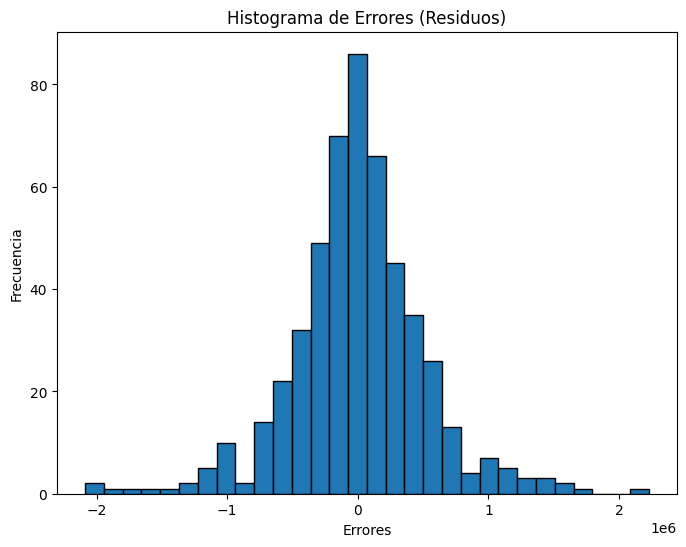

In [86]:
# Histograma de los errores
residuals = y_test_descaled - y_test_pred_descaled

plt.figure(figsize=(8,6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histograma de Errores (Residuos)")
plt.xlabel("Errores")
plt.ylabel("Frecuencia")
plt.show()

In [70]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


#### Gráfico de Dispersión

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


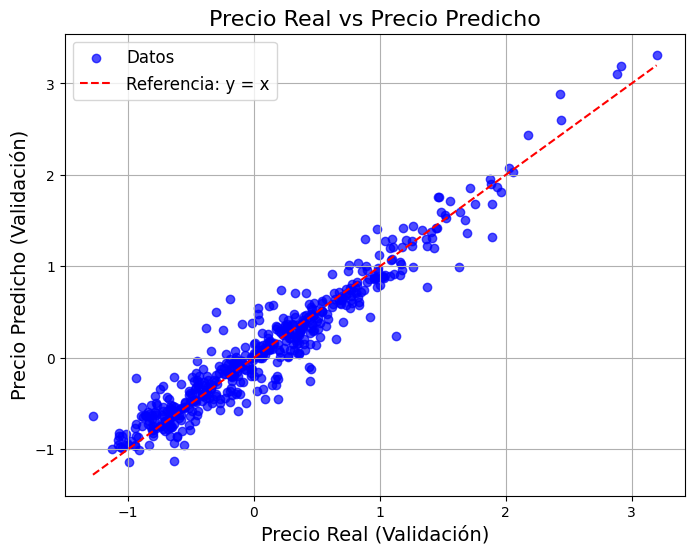

In [88]:
# Hacer las predicciones sobre el conjunto de validación
y_val_pred = final_model.predict(X_val)  # Predicciones para los valores en X_val

# Crear el gráfico de dispersión entre los valores reales y predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.7, label='Datos')  # Valores reales y predichos
plt.xlabel("Precio Real (Validación)", fontsize=14)
plt.ylabel("Precio Predicho (Validación)", fontsize=14)
plt.title("Precio Real vs Precio Predicho", fontsize=16)

# Agregar la línea de referencia (y = x)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="Referencia: y = x")

# Mostrar leyenda
plt.legend(fontsize=12)

# Mostrar cuadrícula
plt.grid(True)
plt.show()


In [73]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


## Guardar el Modelo y Objetos Relacionados

El código siguiente guarda el modelo entrenado y los objetos necesarios para el preprocesamiento de datos, como los escaladores y el transformador de características polinómicas. Esto permite que el modelo entrenado y su configuración se puedan cargar y utilizar posteriormente sin tener que volver a entrenarlo (en la api).

### Guardar el Modelo de Keras
- **final_model.save('modelo_final_escalado.h5')**: Guarda el modelo completo de Keras en un archivo `.h5`. Este archivo contiene tanto la arquitectura del modelo como los pesos aprendidos durante el entrenamiento. Puedes cargar este modelo en cualquier momento para hacer predicciones sobre nuevos datos.

### Guardar los Escaladores
- **scaler_X**: Este objeto es el escalador utilizado para normalizar las características de entrada. Se guarda en un archivo `.pkl` usando `joblib.dump(scaler_X, 'scaler_X.pkl')`. Este archivo se utiliza para aplicar el mismo escalado a nuevas entradas durante la predicción.
- **scaler_y**: Similar al `scaler_X`, este es el escalador utilizado para normalizar la variable objetivo (`y`). Se guarda en un archivo `.pkl` usando `joblib.dump(scaler_y, 'scaler_y.pkl')`.

### Guardar el Transformador de Características Polinómicas
- **poly**: Este objeto transforma las características originales en características polinómicas de grado 2. Se guarda en un archivo `.pkl` usando `joblib.dump(poly, 'poly_features.pkl')`. Esto asegura que las mismas transformaciones se puedan aplicar a nuevos datos.

In [76]:
import joblib

# Guardar el modelo de Keras
final_model.save('modelo_final_escalado.h5')  # Guarda el modelo completo

# Guardar los scalers correctamente
joblib.dump(scaler_X, 'scaler_X.pkl')  # Escalador de las features (X)
joblib.dump(scaler_y, 'scaler_y.pkl')  # Escalador de la variable objetivo (y)

# Guardar el transformador de características polinómicas
joblib.dump(poly, 'poly_features.pkl')


['poly_features.pkl']

### Obtener y Guardar las Columnas Esperadas

El siguiente código genera los nombres de las características polinómicas creadas a partir de las características originales y las guarda en un archivo. Lo necesito en la api.

#### Proceso Descrito:
1. **Generar Nombres de Características Polinómicas**:
   - **poly.get_feature_names_out()**: Obtiene los nombres de las nuevas características generadas por el transformador polinómico (`poly`). Estas características son las interacciones entre las características originales.
   - El parámetro `input_features=df.drop(columns=['price']).columns` asegura que los nombres de las columnas se generen a partir de las características de entrada del DataFrame (sin la columna de precio).

2. **Guardar las Columnas Esperadas**:
   - **joblib.dump(expected_columns, 'expected_columns.pkl')**: Guarda la lista de los nombres de las características esperadas en un archivo `.pkl`. Este archivo se puede usar más adelante para comparar si las características generadas en nuevas predicciones coinciden con las esperadas.

In [77]:
feature_names = poly.get_feature_names_out(input_features=df.drop(columns=['price']).columns)
expected_columns = list(feature_names)
joblib.dump(expected_columns, 'expected_columns.pkl')
print("✅ Columnas finales esperadas:\n", expected_columns)



✅ Columnas finales esperadas:
 ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus_furnished', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished', 'bathrooms_per_area', 'stories_per_area', 'parking_per_area', 'bathrooms_per_bedroom', 'bed_room_per_area', 'rooms_total', 'avg_room_size', 'room_density', 'bedrooms_per_bathroom', 'area_per_story', 'parking_per_bedroom', 'parking_area_ratio', 'service_index', 'parking_service_ratio', 'service_area_ratio', 'guestroom_basement', 'area bedrooms', 'area bathrooms', 'area stories', 'area mainroad', 'area guestroom', 'area basement', 'area hotwaterheating', 'area airconditioning', 'area parking', 'area prefarea', 'area furnishingstatus_furnished', 'area furnishingstatus_semi-furnished', 'area furnishingstatus_unfurnished', 'area bathrooms_per_area', 'area stories_per_area', 'area parking_per_area', 'area bathrooms_per_bedroo